In [ ]:
import os
import shutil
from glob import glob
import random
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Dataset preprocessing

In [ ]:
# Creating folder for train, validation and test datasets
dataset_root = Path("dataset")
classes = ["duck", "chicken"]
splits = ["train", "val", "test"]

for split in splits:
    for cls in classes:
        (dataset_root / split / cls).mkdir(parents=True, exist_ok=True)

In [ ]:
# Read duck and chicken images
duck_images = glob('/kaggle/working/duck_images/*jpg')
chicken_images = glob('/kaggle/working/chicken_images/*jpg')

random.shuffle(chicken_images)
random.shuffle(duck_images)

In [ ]:
# Move images to respective folders
for img in duck_images[:80]:
    shutil.move(img, f"./dataset/train/duck/{img.split('/')[-1]}")

for img in duck_images[80:90]:
    shutil.move(img, f"./dataset/val/duck/{img.split('/')[-1]}")

for img in duck_images[90:]:
    shutil.move(img, f"./dataset/test/duck/{img.split('/')[-1]}")

for img in chicken_images[:80]:
    shutil.move(img, f"./dataset/train/chicken/{img.split('/')[-1]}")

for img in chicken_images[80:90]:
    shutil.move(img, f"./dataset/val/chicken/{img.split('/')[-1]}")

for img in chicken_images[90:]:
    shutil.move(img, f"./dataset/test/chicken/{img.split('/')[-1]}")

# Check if the images are moved correctly
assert len(os.listdir('./dataset/train/duck/')) == 80
assert len(os.listdir('./dataset/val/duck/')) == 10
assert len(os.listdir('./dataset/test/duck/')) == 10
assert len(os.listdir('./dataset/train/chicken/')) == 80
assert len(os.listdir('./dataset/val/chicken/')) == 10
assert len(os.listdir('./dataset/test/chicken/')) == 10

## Model Building

In [ ]:
def get_dataloaders(data_dir, batch_size=32, img_size=(224, 224), num_workers=4):
    """
    Creates PyTorch DataLoaders for train, validation, and test sets.

    Args:
        data_dir (str): Root directory containing 'train', 'val', 'test' folders.
        batch_size (int): Number of samples per batch.
        img_size (tuple): Image size for resizing.
        num_workers (int): Number of worker threads for data loading.

    Returns:
        dict: Dictionary containing 'train', 'val', and 'test' DataLoaders.
    """

    # Define data transformations
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
    ])

    # Load datasets
    datasets_dict = {
        split: datasets.ImageFolder(root=f"{data_dir}/{split}", transform=transform)
        for split in ["train", "val", "test"]
    }

    # Create DataLoaders
    dataloaders = {
        split: DataLoader(datasets_dict[split], batch_size=batch_size, shuffle=(split=="train"), num_workers=num_workers)
        for split in ["train", "val", "test"]
    }

    return dataloaders

# Loading the dataset
data_dir = "/kaggle/working/dataset"
dataloaders = get_dataloaders(data_dir, batch_size=32)

In [ ]:
# Get class names
class_names = dataloaders['train'].dataset.classes
num_classes = len(class_names)

# Load Pretrained ResNet-18 Model
model = models.resnet18(pretrained=True)

# Move model to GPU if available
model = model.to(device)

# Modify the last fully connected layer for custom classification
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [ ]:
# Setting all layers as not trainable except last 3 layers
for layer in list(model.parameters())[:-3]:
    layer.requires_grad = False

In [ ]:
# Printing summary
summary(model.to(device), (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

## Training

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

losses = {
    'train': [],
    'val': []
}

accuracies = {
    'train': [],
    'val': []
}

best_val_loss = float('inf')

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    for split in ["train", "val"]:
        if split == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0

        # Use tqdm to display progress
        progress_bar = tqdm(dataloaders[split], desc=f"{split} Epoch {epoch+1}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(split == "train"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                preds = torch.argmax(outputs, dim=1)

                if split == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item()
            corrects += torch.sum(preds == labels.data).item()
            progress_bar.set_postfix(loss=loss.item())

        # Compute epoch loss and accuracy using dataset size
        epoch_loss = running_loss / len(dataloaders[split].dataset)
        epoch_acc = corrects / len(dataloaders[split].dataset)

        # storing loss and accuracies
        losses[split].append(epoch_loss)
        accuracies[split].append(epoch_acc)

        if split == 'val' and best_val_loss < epoch_loss:
            best_val_loss = epoch_loss
            # Save the trained model
            torch.save(model.state_dict(), "/kaggle/working/resnet18_model.pth")
            print(f"The checkpoint is saved!")

        print(f"Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc}")
    print()

Epoch 1/10


train Epoch 1: 100%|██████████| 5/5 [00:00<00:00,  6.18it/s, loss=0.479]


Loss: 0.0163, Accuracy: 0.7375


val Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  4.95it/s, loss=0.456]


Loss: 0.0228, Accuracy: 0.9

Epoch 2/10


train Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 11.74it/s, loss=0.345]


Loss: 0.0122, Accuracy: 0.90625


val Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  5.29it/s, loss=0.394]


Loss: 0.0197, Accuracy: 0.85

Epoch 3/10


train Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 11.69it/s, loss=0.327]


Loss: 0.0101, Accuracy: 0.925


val Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s, loss=0.32]


Loss: 0.0160, Accuracy: 0.9

Epoch 4/10


train Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 11.81it/s, loss=0.218]


Loss: 0.0077, Accuracy: 0.9375


val Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  5.41it/s, loss=0.284]


Loss: 0.0142, Accuracy: 0.9

Epoch 5/10


train Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 11.91it/s, loss=0.173]


Loss: 0.0068, Accuracy: 0.95625


val Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  5.43it/s, loss=0.261]


Loss: 0.0130, Accuracy: 0.95

Epoch 6/10


train Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 11.95it/s, loss=0.18] 


Loss: 0.0056, Accuracy: 0.9625


val Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s, loss=0.272]


Loss: 0.0136, Accuracy: 0.85

Epoch 7/10


train Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 11.88it/s, loss=0.139]


Loss: 0.0049, Accuracy: 0.975


val Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s, loss=0.227]


Loss: 0.0113, Accuracy: 0.95

Epoch 8/10


train Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 10.97it/s, loss=0.195]


Loss: 0.0047, Accuracy: 0.9625


val Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s, loss=0.216]


Loss: 0.0108, Accuracy: 0.95

Epoch 9/10


train Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 11.78it/s, loss=0.12]  


Loss: 0.0039, Accuracy: 0.99375


val Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.23it/s, loss=0.211]


Loss: 0.0105, Accuracy: 0.95

Epoch 10/10


train Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 11.92it/s, loss=0.103] 


Loss: 0.0034, Accuracy: 0.99375


val Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  5.39it/s, loss=0.213]

Loss: 0.0107, Accuracy: 0.9



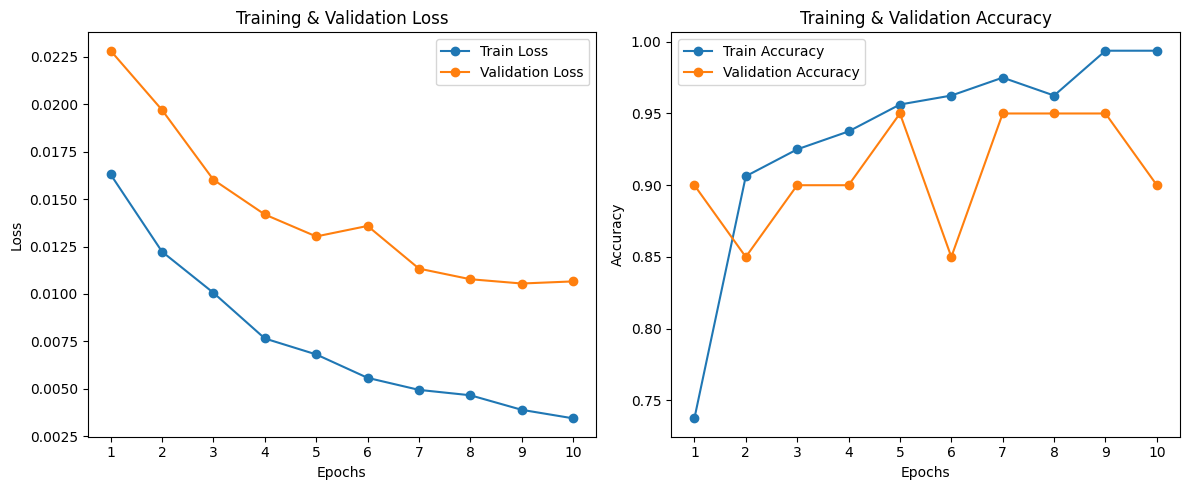

In [ ]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses['train'], label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), losses['val'], label='Validation Loss', marker='o')
plt.xticks(range(1, num_epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies['train'], label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), accuracies['val'], label='Validation Accuracy', marker='o')
plt.xticks(range(1, num_epochs + 1))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Testing

In [ ]:
# Loading the best model and testing on test dataset
model.load_state_dict(torch.load("/kaggle/working/resnet18_model.pth"))
model.to(device)
model.eval()

test_loss = 0
predictions = []
labels = []
with torch.no_grad():
    for input_batch, labels_batch in dataloaders['test']:
        input_batch, labels_batch = input_batch.to(device), labels_batch.to(device)
        output = model(input_batch)
    
        loss = criterion(output, labels_batch)
        preds = output.argmax(dim = 1)

        test_loss += loss.item()
        predictions.extend(preds.cpu().numpy())
        labels.extend(labels_batch.cpu().numpy())

print(f"Total Test Loss: {test_loss:.4f}")

Total Test Loss: 0.1531


In [ ]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.91      0.95        11

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.96      0.95      0.95        20

